<a href="https://colab.research.google.com/github/MiUPa/probspace_taxi/blob/develop/main_miura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
# !pip install catboost
# from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder

#表示するテーブルの最大行と最大列を指定
pd.options.display.max_columns = 100
pd.options.display.max_rows = 999

seed = 42
# 乱数初期化
random.seed(seed)
np.random.seed(seed)

# データの読み込み
train_data = pd.read_csv('train_data.csv')
taxi_zones = pd.read_csv('taxi_zones.csv')
nyc_weather = pd.read_csv('nyc_weather_2017_2019.csv', low_memory=False)
hourly_prec = nyc_weather #[["DATE", "HourlyPrecipitation"]]　なんか二度手間をやってしまったが、もう変更が面倒なので放置

In [100]:
hourly_prec

,DATE,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySkyConditions,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,REM
0,2017-01-01T00:51:00,FM-15,7,29.89,25.0,46.0,0.00,NaN,0.02,6.0,44.0,BKN:07 46 OVC:08 65,29.89,29.86,10.00,38.0,230,NaN,10.0,MET12701/01/17 00:51:02 METAR KLGA 010551Z 230...
1,2017-01-01T01:00:00,FM-12,4,NaN,25.0,46.0,NaN,NaN,0.02,6.0,44.0,41,29.89,29.85,9.94,38.0,230,NaN,10.0,SYN08072503 32666 82309 10078 21039 30108 4012...
2,2017-01-01T01:51:00,FM-15,7,29.90,28.0,45.0,T,NaN,NaN,NaN,52.0,OVC:08 85,29.90,29.87,10.00,38.0,230,NaN,8.0,MET11701/01/17 01:51:02 METAR KLGA 010651Z 230...
3,2017-01-01T02:51:00,FM-15,7,29.91,26.0,46.0,0.00,NaN,NaN,NaN,46.0,FEW:02 55 BKN:07 100,29.91,29.88,10.00,38.0,240,NaN,13.0,MET10901/01/17 02:51:02 METAR KLGA 010751Z 240...
4,2017-01-01T03:51:00,FM-15,7,29.93,25.0,46.0,0.00,NaN,-0.04,3.0,44.0,FEW:02 55 FEW:02 100,29.93,29.90,10.00,38.0,240,25.0,10.0,MET12401/01/17 03:51:02 METAR KLGA 010851Z 240...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40256,2019-12-07T20:51:00,FM-15,7,30.48,15,34,0.00,NaN,NaN,NaN,46.0,CLR:00,30.48,30.45,10.00,28.0,340,NaN,11.0,MET09112/07/19 20:51:01 METAR KLGA 080151Z 340...
40257,2019-12-07T21:51:00,FM-15,7,30.49,15,33,0.00,NaN,-0.04,1.0,47.0,CLR:00,30.48,30.46,10.00,27.0,350,NaN,10.0,MET09712/07/19 21:51:01 METAR KLGA 080251Z 350...
40258,2019-12-07T22:00:00,FM-12,4,NaN,15,33,NaN,NaN,-0.04,1.0,47.0,NaN,30.48,30.45,9.94,27.0,350,NaN,10.0,SYN06472503 32966 03509 10006 21094 30311 4032...
40259,2019-12-07T22:51:00,FM-15,7,30.51,15,32,0.00,NaN,NaN,NaN,50.0,CLR:00,30.51,30.48,10.00,27.0,010,NaN,8.0,MET09612/07/19 22:51:03 METAR KLGA 080351Z 010...


In [101]:
#データを使いやすい形に整形

#全地区乗車実績の平均列を追加
#各区間で規格化したほうがよいのでは？
train_data['mean'] = train_data.loc[:, '0':'78'].mean(axis=1)

# train_dataの日時カラムを変換
train_data['tpep_pickup_datetime'] = pd.to_datetime(train_data['tpep_pickup_datetime'])
train_data['year'] = train_data['tpep_pickup_datetime'].dt.year
train_data['month'] = train_data['tpep_pickup_datetime'].dt.month
train_data['day'] = train_data['tpep_pickup_datetime'].dt.day
train_data['hour'] = train_data['tpep_pickup_datetime'].dt.hour
train_data['minute'] = train_data['tpep_pickup_datetime'].dt.minute
train_data['weekday'] = train_data['tpep_pickup_datetime'].dt.weekday
#一年のうち第何週かを追加
train_data['weekOfYear'] = train_data['tpep_pickup_datetime'].dt.strftime('%U').astype('category')
train_data

,tpep_pickup_datetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,mean,year,month,day,hour,minute,weekday,weekOfYear
0,2017-01-01 00:00:00,53.0,16.0,45.0,38.0,12.0,6.0,2.0,47.0,31.0,238.0,27.0,311.0,118.0,0.0,10.0,7.0,301.0,43.0,65.0,478.0,57.0,31.0,212.0,7.0,48.0,245.0,143.0,216.0,23.0,43.0,8.0,179.0,111.0,34.0,86.0,205.0,382.0,89.0,127.0,3.0,9.0,296.0,95.0,15.0,179.0,337.0,168.0,108.0,212.0,43.0,267.0,10.0,14.0,138.0,0.0,22.0,97.0,8.0,19.0,10.0,193.0,19.0,134.0,41.0,75.0,294.0,198.0,301.0,174.0,260.0,12.0,139.0,253.0,17.0,33.0,5.0,14.0,92.0,201.0,108.848101,2017,1,1,0,0,6,01
1,2017-01-01 00:30:00,83.0,62.0,59.0,56.0,19.0,26.0,8.0,91.0,48.0,165.0,27.0,389.0,198.0,9.0,22.0,16.0,365.0,84.0,85.0,598.0,93.0,39.0,258.0,18.0,52.0,384.0,175.0,192.0,47.0,56.0,18.0,84.0,195.0,19.0,144.0,320.0,357.0,146.0,145.0,28.0,12.0,298.0,144.0,25.0,118.0,316.0,251.0,115.0,267.0,71.0,408.0,15.0,39.0,198.0,7.0,27.0,87.0,15.0,42.0,30.0,332.0,12.0,212.0,55.0,130.0,439.0,328.0,435.0,281.0,357.0,45.0,159.0,280.0,46.0,50.0,10.0,30.0,110.0,349.0,143.354430,2017,1,1,0,30,6,01
2,2017-01-01 01:00:00,69.0,83.0,58.0,45.0,21.0,27.0,23.0,102.0,62.0,113.0,25.0,384.0,189.0,12.0,29.0,10.0,379.0,79.0,91.0,550.0,101.0,48.0,246.0,30.0,73.0,410.0,129.0,127.0,55.0,64.0,11.0,87.0,205.0,2.0,141.0,372.0,350.0,112.0,119.0,34.0,24.0,269.0,136.0,41.0,96.0,318.0,206.0,96.0,287.0,67.0,432.0,28.0,73.0,280.0,6.0,31.0,73.0,34.0,61.0,36.0,329.0,51.0,208.0,89.0,146.0,326.0,244.0,363.0,276.0,355.0,74.0,193.0,232.0,71.0,54.0,10.0,34.0,124.0,386.0,142.101266,2017,1,1,1,0,6,01
3,2017-01-01 01:30:00,76.0,87.0,56.0,36.0,27.0,18.0,25.0,84.0,87.0,81.0,35.0,369.0,146.0,11.0,35.0,8.0,234.0,84.0,88.0,549.0,152.0,41.0,139.0,38.0,82.0,449.0,109.0,122.0,90.0,74.0,27.0,37.0,237.0,1.0,111.0,301.0,277.0,92.0,115.0,45.0,33.0,301.0,100.0,28.0,103.0,278.0,219.0,135.0,248.0,54.0,528.0,31.0,83.0,231.0,2.0,42.0,58.0,42.0,56.0,48.0,313.0,66.0,237.0,104.0,144.0,195.0,217.0,269.0,236.0,328.0,61.0,137.0,208.0,68.0,75.0,12.0,44.0,91.0,373.0,132.569620,2017,1,1,1,30,6,01
4,2017-01-01 02:00:00,101.0,113.0,43.0,33.0,32.0,24.0,14.0,88.0,69.0,68.0,31.0,468.0,167.0,16.0,24.0,3.0,243.0,92.0,88.0,511.0,99.0,50.0,133.0,28.0,62.0,407.0,91.0,100.0,69.0,79.0,36.0,22.0,194.0,0.0,88.0,282.0,249.0,87.0,142.0,36.0,39.0,397.0,91.0,35.0,94.0,242.0,285.0,159.0,300.0,39.0,467.0,37.0,70.0,217.0,9.0,37.0,67.0,43.0,68.0,66.0,268.0,114.0,259.0,83.0,122.0,182.0,161.0,181.0,173.0,320.0,63.0,125.0,179.0,87.0,78.0,22.0,53.0,85.0,341.0,128.354430,2017,1,1,2,0,6,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51067,2019-11-30 21:30:00,15.0,3.0,13.0,9.0,1.0,1.0,1.0,13.0,6.0,52.0,13.0,221.0,28.0,1.0,3.0,2.0,153.0,17.0,26.0,172.0,30.0,15.0,91.0,3.0,106.0,113.0,107.0,111.0,3.0,27.0,0.0,231.0,42.0,188.0,43.0,135.0,279.0,44.0,77.0,6.0,3.0,77.0,28.0,0.0,63.0,212.0,155.0,149.0,131.0,11.0,131.0,1.0,11.0,360.0,1.0,18.0,56.0,2.0,4.0,4.0,86.0,213.0,74.0,6.0,48.0,158.0,132.0,134.0,70.0,126.0,3.0,70.0,167.0,1.0,6.0,2.0,21.0,30.0,75.0,66.329114,2019,11,30,21,30,5,47
51068,2019-11-30 22:00:00,8.0,1.0,7.0,7.0,6.0,2.0,0.0,23.0,5.0,31.0,12.0,220.0,40.0,4.0,2.0,3.0,141.0,14.0,27.0,211.0,32.0,14.0,71.0,4.0,116.0,134.0,109.0,106.0,1.0,20.0,1.0,195.0,48.0,182.0,48.0,107.0,402.0,66.0,74.0,3.0,4.0,82.0,27.0,6.0,60.0,221.0,101.0,124.0,131.0,20.0,102.0,2.0,2.0,197.0,1.0,13.0,58.0,3.0,4.0,7.0,98.0,308.0,60.0,5.0,39.0,164.0,123.0,152.0,77.0,185.0,4.0,70.0,167.0,4.0,2.0,1.0,12.0,30.0,85.0,66.430380,2019,11,30,22,0,5,47
51069,2019-11-30 22:30:00,8.0,3.0,13.0,16.0,3.0,5.0,1.0,16.0,9.0,

In [102]:
#日付をDATETIME形式に変更
hourly_prec["DATE"] = pd.to_datetime(hourly_prec["DATE"])

#hourly_precに30分刻み時間を追加する前準備
#30分ごとに時間が追加されているDATE列をつくる
date_range = pd.DataFrame()
date_range["DATE"]= pd.date_range(start='2017-01-01', end='2019-12-07 23:30:00', freq='30T')
date_range["HourlyPrecipitation"] = pd.NA

#気候データに30分刻みの時刻を挿入し、昇順に並び替え
hourly_prec = pd.concat([hourly_prec, date_range])
hourly_prec = hourly_prec.sort_values('DATE')
'''
hourly_prec['year'] = hourly_prec['DATE'].dt.year
hourly_prec['month'] = hourly_prec['DATE'].dt.month
hourly_prec['day'] = hourly_prec['DATE'].dt.day
hourly_prec['hour'] = hourly_prec['DATE'].dt.hour
hourly_prec['weekday'] = hourly_prec['DATE'].dt.weekday
'''

#空欄のセルについて、上または下の数値で補完
#hourly_prec["HourlyPrecipitation"] = hourly_prec["HourlyPrecipitation"].fillna(method='ffill').fillna(method='bfill')
#hourly_prec["snow"] = hourly_prec["snow"].fillna(method='ffill').fillna(method='bfill')
hourly_prec = hourly_prec.ffill().bfill() #fillna(method='ffill').fillna(method='bfill') method使ったらなんか指導入る

#日付が重複している行を削除
hourly_prec = hourly_prec.drop_duplicates(subset='DATE')

#0分か30分のものだけ残す
hourly_prec = hourly_prec[hourly_prec['DATE'].dt.minute.isin([0,30])]

#hourly_precにwindChill(35.74 + 0.6215T-35.75*V^0.16 + 0.4275*T*V^0.16 )カラムを追加してみる
# T:気温 V:風速
T = pd.to_numeric(hourly_prec['HourlyDryBulbTemperature'])
V = pd.to_numeric(hourly_prec['HourlyWindSpeed'])
hourly_prec['windChill'] = (35.4 + 0.6215 * T - 35.75 * (V**0.16) + 0.4275 * T * (V**0.16))

#hourly_precにheatIndex(-42.379 + (2.04901523 * T) + (10.14333127 * R) - (0.22475541 * TR)  - (6.83783e-3 * TT) - (5.481717e-2 * RR) + (1.22874e-3 * TTR) + (8.5282e-4 * TRR) - (1.99e-6 * TTRR))カラムを追加してみる
# T:気温　R：相対湿度
R = pd.to_numeric(hourly_prec['HourlyRelativeHumidity'])
hourly_prec['heatIndex'] = (-42.379 + (2.04901523 * T) + (10.14333127 * R) - (0.22475541 * T * R)  - (6.83783e-3 * T * T) - (5.481717e-2 * R * R) + (1.22874e-3 * T * T * R) + (8.5282e-4 * T * R * R) - (1.99e-6 * T * T * R * R))

#欠損値がないか確認
hourly_prec.isnull().any()

DATE                         False
REPORT_TYPE                  False
SOURCE                       False
HourlyAltimeterSetting       False
HourlyDewPointTemperature    False
HourlyDryBulbTemperature     False
HourlyPrecipitation          False
HourlyPresentWeatherType     False
HourlyPressureChange         False
HourlyPressureTendency       False
HourlyRelativeHumidity       False
HourlySkyConditions          False
HourlySeaLevelPressure       False
HourlyStationPressure        False
HourlyVisibility             False
HourlyWetBulbTemperature     False
HourlyWindDirection          False
HourlyWindGustSpeed          False
HourlyWindSpeed              False
REM                          False
windChill                    False
heatIndex                    False
dtype: bool

グラフで相関とか確認してみるゾーン

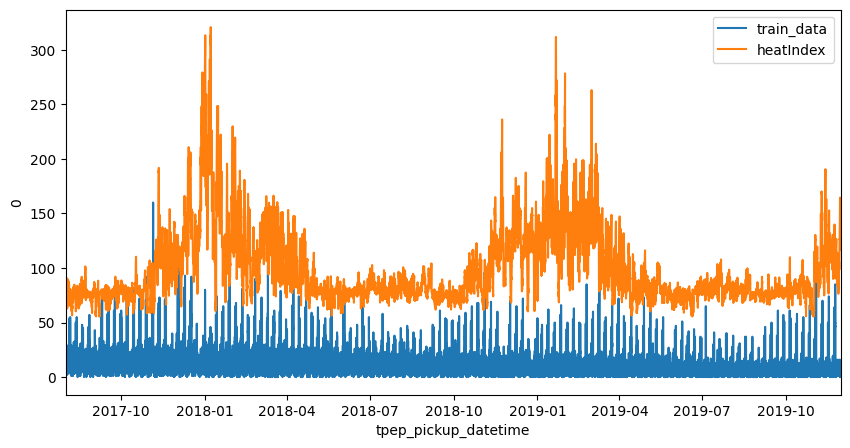

In [103]:
#0地区の乗車実績とheatIndexの相関 heatIndexが増えると乗車が増えそう

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='tpep_pickup_datetime', y='0', data=train_data, ax = ax, label='train_data')
sns.lineplot(x='DATE', y='heatIndex', data=hourly_prec, ax = ax, label='heatIndex')
plt.xlim(pd.to_datetime('2017-08-01'), pd.to_datetime('2019-11-30'))
plt.legend()
plt.show()

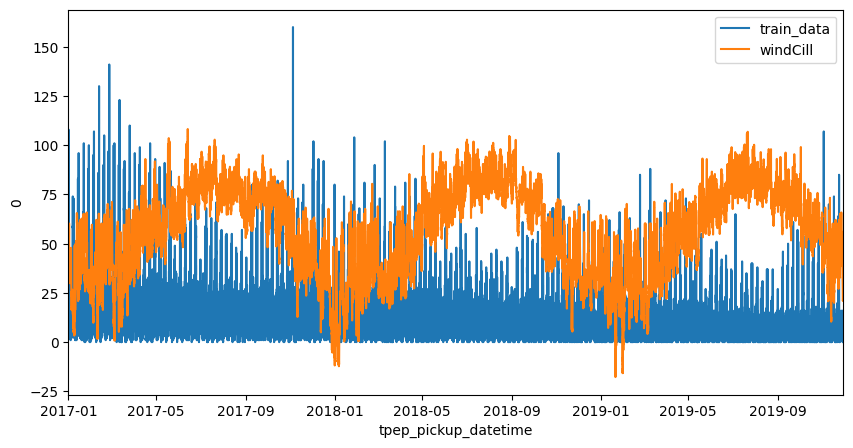

In [104]:
#0地区の乗車実績とwindChillの相関 windChillが下がると乗車が増えそう

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='tpep_pickup_datetime', y='0', data=train_data, ax = ax, label='train_data')
sns.lineplot(x='DATE', y='windChill', data=hourly_prec, ax = ax, label='windCill')
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2019-11-30'))
plt.legend()
plt.show()

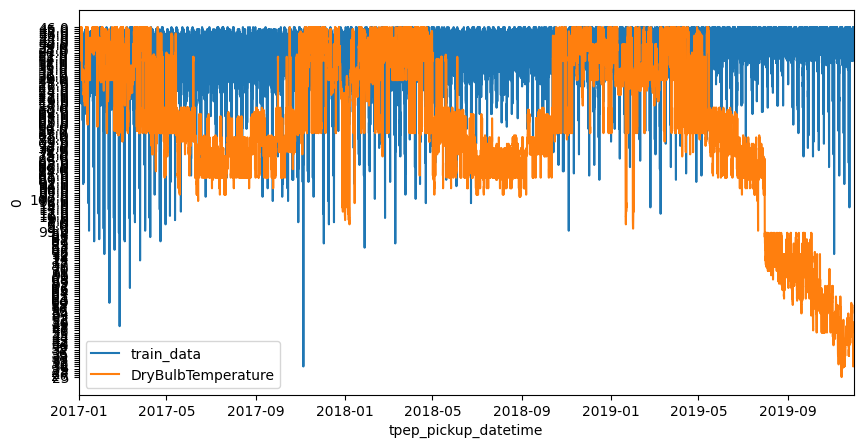

In [105]:
#0地区の乗車実績と気温の相関 気温が下がると乗車が増えそう

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='tpep_pickup_datetime', y='0', data=train_data, ax = ax, label='train_data')
sns.lineplot(x='DATE', y='HourlyDryBulbTemperature', data=hourly_prec, ax = ax, label='DryBulbTemperature')
#sns.lineplot(x='DATE', y='HourlyWetBulbTemperature', data=hourly_prec, ax = ax, label='WetBulbTemperature')
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2019-11-30'))
plt.legend()
plt.show()


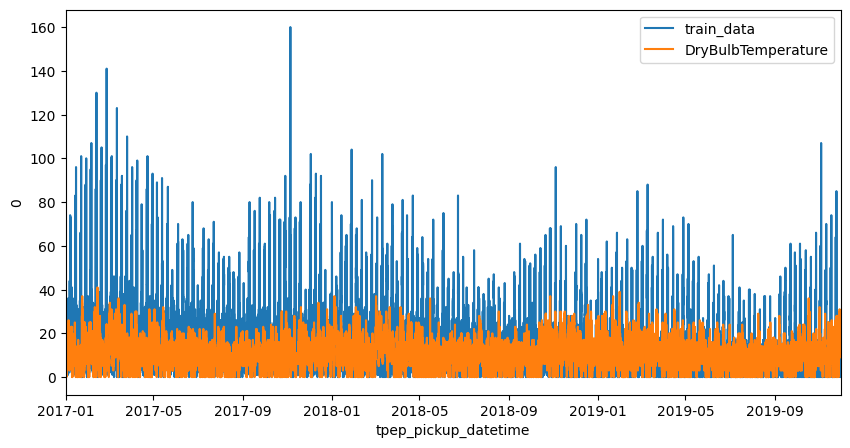

In [106]:
#0地区の乗車実績と風速の相関 風が強いと乗車が増えてそうな気がする

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='tpep_pickup_datetime', y='0', data=train_data, ax = ax, label='train_data')
sns.lineplot(x='DATE', y='HourlyWindSpeed', data=hourly_prec, ax = ax, label='DryBulbTemperature')
#sns.lineplot(x='DATE', y='HourlyWetBulbTemperature', data=hourly_prec, ax = ax, label='WetBulbTemperature')
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2019-11-30'))
plt.legend()
plt.show()

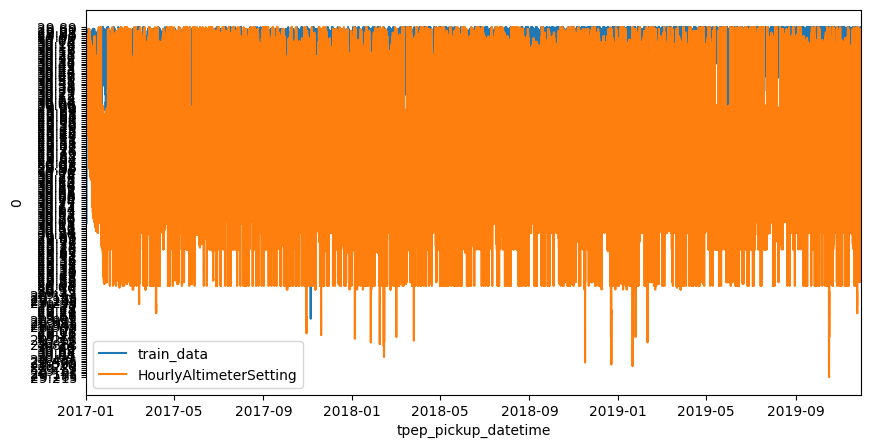

In [107]:
#0地区の乗車実績と高度計の設定 関係ないな

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x='tpep_pickup_datetime', y='0', data=train_data, ax = ax, label='train_data')
sns.lineplot(x='DATE', y='HourlyAltimeterSetting', data=hourly_prec, ax = ax, label='HourlyAltimeterSetting')
#sns.lineplot(x='DATE', y='HourlyWetBulbTemperature', data=hourly_prec, ax = ax, label='WetBulbTemperature')
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2019-11-30'))
plt.legend()
plt.show()

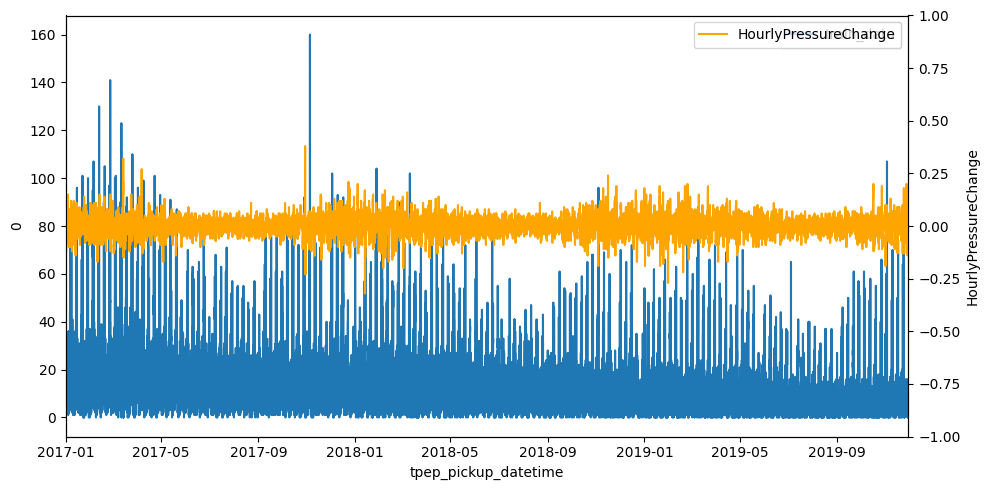

In [108]:
#0地区の乗車実績と気圧変化の関係 大きいときは乗車実績も増えるかも　絶対値にしてみようか
indicator = 'HourlyPressureChange'
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax1 = fig.subplots()
ax2 = ax1.twinx()
ax2.set_ylim(-1, 1)
# fig, ax1 = plt.subplots(figsize=(10, 5))
# fig, ax2 = plt.subplots(figsize=(10, 5))
sns.lineplot(x='tpep_pickup_datetime', y='0', data=train_data, ax = ax1, label='train_data')
sns.lineplot(x='DATE', y=indicator, data=hourly_prec, ax = ax2, label=indicator, color='orange')
#sns.lineplot(x='DATE', y='HourlyWetBulbTemperature', data=hourly_prec, ax = ax, label='WetBulbTemperature')
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2019-11-30'))
#plt.legend()
plt.tight_layout()
plt.show()

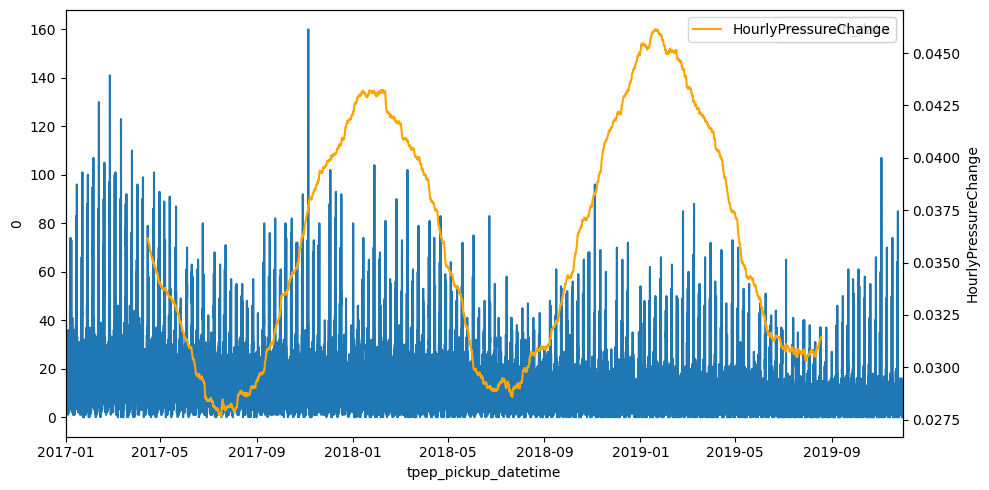

In [109]:
#0地区乗車実績と気圧変化の絶対値　相関ありそう
rollNumber = 10000
pressureChangeAbs = pd.DataFrame()
pressureChangeAbs.loc[:, 'DATE'] = train_data['tpep_pickup_datetime'].reset_index(drop=True)
pressureChangeAbs.loc[:, 'HourlyPressureChange'] = hourly_prec['HourlyPressureChange'].abs().reset_index(drop=True)

pressureChangeAbs.loc[:, 'HourlyPressureChange'] = pressureChangeAbs.loc[:, 'HourlyPressureChange'].rolling(rollNumber, center=True).mean()

#0地区の乗車実績と気圧変化の関係 大きいときは乗車実績も増えるかも　絶対値にしてみようか
indicator = 'HourlyPressureChange'
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax1 = fig.subplots()
ax2 = ax1.twinx()
# ax2.set_ylim(-1, 1)
# fig, ax1 = plt.subplots(figsize=(10, 5))
# fig, ax2 = plt.subplots(figsize=(10, 5))
sns.lineplot(x='tpep_pickup_datetime', y='0', data=train_data, ax = ax1, label='train_data')
sns.lineplot(x='DATE', y=indicator, data=pressureChangeAbs, ax = ax2, label=indicator, color='orange')
#sns.lineplot(x='DATE', y='HourlyWetBulbTemperature', data=hourly_prec, ax = ax, label='WetBulbTemperature')
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2019-11-30'))
#plt.legend()
plt.tight_layout()
plt.show()

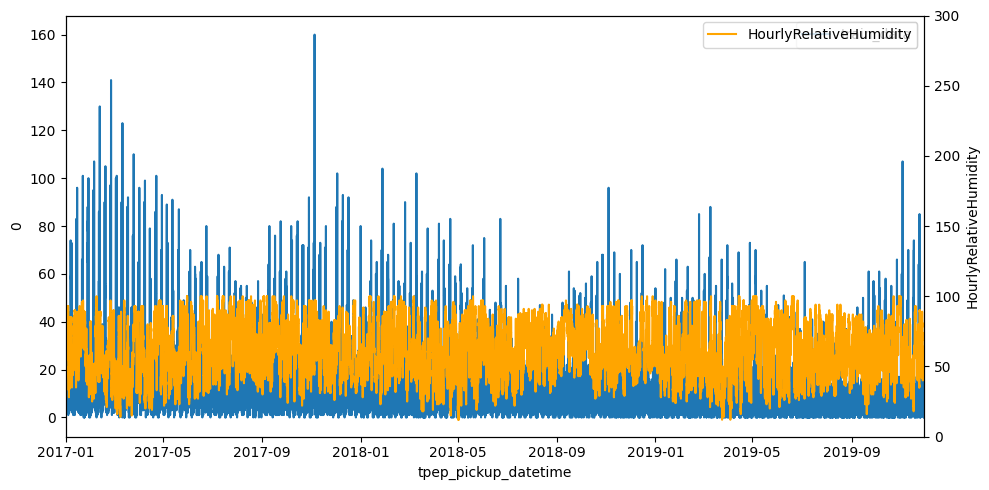

In [110]:
#0地区の乗車実績と湿度の設定 あまり関係なさそう
indicater = 'HourlyRelativeHumidity'
fig = plt.figure(figsize=(10, 5), facecolor="w")
ax1 = fig.subplots()
ax2 = ax1.twinx()
ax2.set_ylim(0, 300)
# fig, ax1 = plt.subplots(figsize=(10, 5))
# fig, ax2 = plt.subplots(figsize=(10, 5))
sns.lineplot(x='tpep_pickup_datetime', y='0', data=train_data, ax = ax1, label='train_data')
sns.lineplot(x='DATE', y=indicater, data=hourly_prec, ax = ax2, label=indicater, color='orange')
#sns.lineplot(x='DATE', y='HourlyWetBulbTemperature', data=hourly_prec, ax = ax, label='WetBulbTemperature')
plt.xlim(pd.to_datetime('2017-01-01'), pd.to_datetime('2019-11-30'))
#plt.legend()
plt.tight_layout()
plt.show()

In [111]:
#HourlyPrecipitation列にs(snow)を含んだデータはいくつある？
'''
df = hourly_prec['HourlyPrecipitation']
df = pd.DataFrame(df)
count_s = (df.apply(lambda x: x.astype(str).str.contains('s')).sum()).sum()
print(count_s)
'''

#snowという新しい特徴量をHourlyPrecipitationから作る
#sが入っていたら降雪あり"1"、なければ"0"
hourly_prec['snow'] = hourly_prec['HourlyPrecipitation'].apply(lambda x: '1' if 's' in str(x) else '0').astype('category')

#降水量T（微量の降雨）を0に変換　欠損地はそのままでいいかな、lightGBMだし
hourly_prec["HourlyPrecipitation"] = hourly_prec["HourlyPrecipitation"].replace("T", 0)

#降水量を数値に変換し、できないものは空欄に
hourly_prec["HourlyPrecipitation"] = pd.to_numeric(hourly_prec["HourlyPrecipitation"], errors='coerce').ffill().bfill()

#気圧変化の絶対値pressureChangeAbsをつくる
hourly_prec['pressureChangeAbs'] = hourly_prec['HourlyPressureChange'].abs().rolling(rollNumber, center=True).mean()

# HourlySkyConditionsをラベルエンコーディング
le = LabelEncoder()
hourly_prec['HourlySkyConditions'] = le.fit_transform(hourly_prec['HourlySkyConditions'])
hourly_prec['HourlySkyConditions'] = hourly_prec['HourlySkyConditions'].astype('category')

#その他データも数値に変えられそうなものは降水量同様に数値に変換しておく
change_features = ['HourlyAltimeterSetting', 'HourlyDewPointTemperature',
                   'HourlyDryBulbTemperature',
                   'HourlyPresentWeatherType',
                   'HourlySeaLevelPressure',
                   'HourlyStationPressure',
                   'HourlyVisibility',
                   'HourlyWindDirection',
                   'pressureChangeAbs'
                   ]
for feature in change_features:
     hourly_prec[feature] = pd.to_numeric(hourly_prec[feature], errors='coerce').ffill().bfill()

hourly_prec.isnull().sum()

DATE                             0
REPORT_TYPE                      0
SOURCE                           0
HourlyAltimeterSetting           0
HourlyDewPointTemperature        0
HourlyDryBulbTemperature         0
HourlyPrecipitation              0
HourlyPresentWeatherType     51408
HourlyPressureChange             0
HourlyPressureTendency           0
HourlyRelativeHumidity           0
HourlySkyConditions              0
HourlySeaLevelPressure           0
HourlyStationPressure            0
HourlyVisibility                 0
HourlyWetBulbTemperature         0
HourlyWindDirection              0
HourlyWindGustSpeed              0
HourlyWindSpeed                  0
REM                              0
windChill                        0
heatIndex                        0
snow                             0
pressureChangeAbs                0
dtype: int64

In [112]:
hourly_prec

,DATE,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySkyConditions,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,REM,windChill,heatIndex,snow,pressureChangeAbs
0,2017-01-01 00:00:00,FM-15,7.0,29.89,25.0,46.0,0.0,NaN,0.02,6.0,44.0,1388,29.89,29.86,10.00,38.0,230.0,25.0,10.0,MET12701/01/17 00:51:02 METAR KLGA 010551Z 230...,40.739101,104.879598,0,0.036154
1,2017-01-01 00:30:00,FM-15,7.0,29.89,25.0,46.0,0.0,NaN,0.02,6.0,44.0,1388,29.89,29.86,10.00,38.0,230.0,25.0,10.0,MET12701/01/17 00:51:02 METAR KLGA 010551Z 230...,40.739101,104.879598,0,0.036154
2,2017-01-01 01:00:00,FM-15,7.0,29.89,25.0,46.0,0.0,NaN,0.02,6.0,44.0,1388,29.89,29.86,10.00,38.0,230.0,25.0,10.0,MET12701/01/17 00:51:02 METAR KLGA 010551Z 230...,40.739101,104.879598,0,0.036154
3,2017-01-01 01:30:00,FM-12,4.0,29.89,25.0,46.0,0.0,NaN,0.02,6.0,44.0,11,29.89,29.85,9.94,38.0,230.0,25.0,10.0,SYN08072503 32666 82309 10078 21039 30108 4012...,40.739101,104.879598,0,0.036154
4,2017-01-01 02:00:00,FM-15,7.0,29.90,28.0,45.0,0.0,NaN,0.02,6.0,52.0,6307,29.90,29.87,10.00,38.0,230.0,25.0,8.0,MET11701/01/17 01:51:02 METAR KLGA 010651Z 230...,40.336795,111.541034,0,0.036154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51403,2019-12-07 21:30:00,FM-15,7.0,30.48,15.0,34.0,0.0,NaN,-0.07,1.0,46.0,2028,30.48,30.45,10.00,28.0,340.0,23.0,11.0,MET09112/07/19 20:51:01 METAR KLGA 080151Z 340...,25.394782,140.292661,0,0.031835
40258,2019-12-07 22:00:00,FM-12,4.0,30.49,15.0,33.0,0.0,NaN,-0.04,1.0,47.0,2028,30.48,30.45,9.94,27.0,350.0,23.0,10.0,SYN06472503 32966 03509 10006 21094 30311 4032...,24.626570,145.113379,0,0.031835
51405,2019-12-07 22:30:00,FM-12,4.0,30.49,15.0,33.0,0.0,NaN,-0.04,1.0,47.0,2028,30.48,30.45,9.94,27.0,350.0,23.0,10.0,SYN06472503 32966 03509 10006 21094 30311 4032...,24.626570,145.113379,0,0.031835
51406,2019-12-07 23:00:00,FM-15,7.0,30.51,15.0,32.0,0.0,NaN,-0.04,1.0,50.0,2028,30.51,30.48,10.00,27.0,10.0,23.0,8.0,MET09612/07/19 22:51:03 METAR KLGA 080351Z 010...,24.506007,152.745220,0,0.031835


In [113]:
#train_dataに気象情報追加
#train_data['HourlyPrecipitation'] =
#train_data.head()
#print(len(train_data["tpep_pickup_datetime"]))

train_data = train_data.reset_index(drop=True)
hourly_prec = hourly_prec.reset_index(drop=True)
train_data = pd.concat([train_data, hourly_prec], axis=1)
train_data
# test = train_data[change_features]
# test
#.iloc[:len(train_data["tpep_pickup_datetime"])]
#train_data.loc[change_features].corr()

,tpep_pickup_datetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,mean,year,month,day,hour,minute,weekday,weekOfYear,DATE,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySkyConditions,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,REM,windChill,heatIndex,snow,pressureChangeAbs
0,2017-01-01 00:00:00,53.0,16.0,45.0,38.0,12.0,6.0,2.0,47.0,31.0,238.0,27.0,311.0,118.0,0.0,10.0,7.0,301.0,43.0,65.0,478.0,57.0,31.0,212.0,7.0,48.0,245.0,143.0,216.0,23.0,43.0,8.0,179.0,111.0,34.0,86.0,205.0,382.0,89.0,127.0,3.0,9.0,296.0,95.0,15.0,179.0,337.0,168.0,108.0,212.0,...,19.0,134.0,41.0,75.0,294.0,198.0,301.0,174.0,260.0,12.0,139.0,253.0,17.0,33.0,5.0,14.0,92.0,201.0,108.848101,2017.0,1.0,1.0,0.0,0.0,6.0,01,2017-01-01 00:00:00,FM-15,7.0,29.89,25.0,46.0,0.0,NaN,0.02,6.0,44.0,1388,29.89,29.86,10.00,38.0,230.0,25.0,10.0,MET12701/01/17 00:51:02 METAR KLGA 010551Z 230...,40.739101,104.879598,0,0.036154
1,2017-01-01 00:30:00,83.0,62.0,59.0,56.0,19.0,26.0,8.0,91.0,48.0,165.0,27.0,389.0,198.0,9.0,22.0,16.0,365.0,84.0,85.0,598.0,93.0,39.0,258.0,18.0,52.0,384.0,175.0,192.0,47.0,56.0,18.0,84.0,195.0,19.0,144.0,320.0,357.0,146.0,145.0,28.0,12.0,298.0,144.0,25.0,118.0,316.0,251.0,115.0,267.0,...,12.0,212.0,55.0,130.0,439.0,328.0,435.0,281.0,357.0,45.0,159.0,280.0,46.0,50.0,10.0,30.0,110.0,349.0,143.354430,2017.0,1.0,1.0,0.0,30.0,6.0,01,2017-01-01 00:30:00,FM-15,7.0,29.89,25.0,46.0,0.0,NaN,0.02,6.0,44.0,1388,29.89,29.86,10.00,38.0,230.0,25.0,10.0,MET12701/01/17 00:51:02 METAR KLGA 010551Z 230...,40.739101,104.879598,0,0.036154
2,2017-01-01 01:00:00,69.0,83.0,58.0,45.0,21.0,27.0,23.0,102.0,62.0,113.0,25.0,384.0,189.0,12.0,29.0,10.0,379.0,79.0,91.0,550.0,101.0,48.0,246.0,30.0,73.0,410.0,129.0,127.0,55.0,64.0,11.0,87.0,205.0,2.0,141.0,372.0,350.0,112.0,119.0,34.0,24.0,269.0,136.0,41.0,96.0,318.0,206.0,96.0,287.0,...,51.0,208.0,89.0,146.0,326.0,244.0,363.0,276.0,355.0,74.0,193.0,232.0,71.0,54.0,10.0,34.0,124.0,386.0,142.101266,2017.0,1.0,1.0,1.0,0.0,6.0,01,2017-01-01 01:00:00,FM-15,7.0,29.89,25.0,46.0,0.0,NaN,0.02,6.0,44.0,1388,29.89,29.86,10.00,38.0,230.0,25.0,10.0,MET12701/01/17 00:51:02 METAR KLGA 010551Z 230...,40.739101,104.879598,0,0.036154
3,2017-01-01 01:30:00,76.0,87.0,56.0,36.0,27.0,18.0,25.0,84.0,87.0,81.0,35.0,369.0,146.0,11.0,35.0,8.0,234.0,84.0,88.0,549.0,152.0,41.0,139.0,38.0,82.0,449.0,109.0,122.0,90.0,74.0,27.0,37.0,237.0,1.0,111.0,301.0,277.0,92.0,115.0,45.0,33.0,301.0,100.0,28.0,103.0,278.0,219.0,135.0,248.0,...,66.0,237.0,104.0,144.0,195.0,217.0,269.0,236.0,328.0,61.0,137.0,208.0,68.0,75.0,12.0,44.0,91.0,373.0,132.569620,2017.0,1.0,1.0,1.0,30.0,6.0,01,2017-01-01 01:30:00,FM-12,4.0,29.89,25.0,46.0,0.0,NaN,0.02,6.0,44.0,11,29.89,29.85,9.94,38.0,230.0,25.0,10.0,SYN08072503 32666 82309 10078 21039 30108 4012...,40.739101,104.879598,0,0.036154
4,2017-01-01 02:00:00,101.0,113.0,43.0,33.0,32.0,24.0,14.0,88.0,69.0,68.0,31.0,468.0,167.0,16.0,24.0,3.0,243.0,92.0,88.0,511.0,99.0,50.0,133.0,28.0,62.0,407.0,91.0,100.0,69.0,79.0,36.0,22.0,194.0,0.0,88.0,282.0,249.0,87.0,142.0,36.0,39.0,397.0,91.0,35.0,94.0,242.0,285.0,159.0,300.0,...,114.0,259.0,83.0,122.0,182.0,161.0,181.0,173.0,320.0,63.0,125.0,179.0,87.0,78.0,22.0,53.0,85.0,341.0,128.354430,2017.0,1.0,1.0,2.0,0.0,6.0,01,2017-01-01 02:00:00,FM-15,7.0,29.90,28.0,45.0,0.0,NaN,0.02,6.0,52.0,6307,29.90,29.87,10.00,38.0,230.0,25.0,8.0,MET11701/01/17 01:51:02 METAR KLGA 010651Z 230...,40.336795,111.541034,0,0.036154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [114]:
#乗車実績の平均値meanと気象データの相関をみてみる
# temp = change_features.append('mean')
# # print(change_features)
# dropColumn = [str(i) for i in range(79)]
# train_data.iloc[:51072, :].drop(['REPORT_TYPE', 'HourlySkyConditions', 'REM'], axis=1).drop(dropColumn,axis=1).corr()

In [115]:
#統計量確認
train_data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,mean,year,month,day,hour,minute,weekday,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,windChill,heatIndex,pressureChangeAbs
count,51072.000000,51072.000000,51072.00000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,...,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.000000,51072.00000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,0.0,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000,51408.000000
mean,12.393758,9.322662,52.37921,16.919858,5.738350,6.129778,3.011905,21.328399,9.577714,83.725172,12.577205,181.909814,53.344886,3.190457,7.553708,2.839951,136.042587,21.925380,39.859375,158.191690,43.458196,22.773888,104.145089,5.236999,118.183486,134.745320,91.279899,77.194373,6.671777,33.522302,3.157033,152.777608,70.914121,154.952322,98.654644,132.639215,169.813675,64.328693,60.494596,7.075873,5.777961,78.378485,49.825912,5.665688,60.725486,223.413299,201.139959,153.486470,137.355204,29.751997,...,11.685894,46.167430,3.111411,13.696546,9.187108,108.313283,195.693668,100.126057,9.765488,75.268210,181.182115,213.204868,235.300419,110.329554,146.739329,5.937578,84.803865,115.529860,5.977169,4.822349,3.204378,34.050576,67.658815,104.013393,71.103920,2017.970865,6.366541,15.712406,11.500000,15.000000,3.00000,6.288321,30.030093,42.710920,57.125000,0.004520,NaN,0.001649,4.937092,61.349498,30.028033,29.997791,9.262365,50.182228,187.335240,23.387333,10.799934,54.737543,98.794318,0.035432
std,11.191640,6.137897,36.44926,10.526392,4.456488,5.450804,3.569364,12.824115,6.697653,64.335985,8.388227,87.215140,30.566504,3.987509,5.190602,2.878914,65.372561,12.780538,23.033036,130.553033,26.643741,15.845510,55.741363,4.974977,58.329907,73.811229,53.873808,62.345095,4.722710,20.001034,2.795528,87.996542,38.813716,116.964744,69.212304,76.317614,112.488212,43.498529,44.013000,4.654605,3.814865,99.837528,32.480454,3.951870,42.609674,155.537853,133.471085,96.258523,72.180398,19.412021,...,7.966832,31.306364,2.765838,10.523513,6.167351,62.961867,112.026561,58.403084,8.573116,47.709702,114.503900,160.356668,169.065572,71.905824,93.467712,4.428518,51.191783,75.861795,9.125089,7.151301,2.950748,23.691374,51.620492,56.723761,35.474454,0.810012,3.366867,8.791850,6.922254,15.000147,2.00002,1.271700,0.238094,19.229961,17.964154,0.030444,NaN,0.048278,2.763622,18.630040,0.237547,0.237919,2.146969,16.177085,111.393682,4.697605,5.528288,22.766845,32.908237,0.005059
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [116]:
# 欠損値確認
if train_data.isna().sum().sum() == 0:
    print("train_dataに欠損値はありません")
else:
    print("train_dataに欠損値があります")
'''
if(all(train_data.dropna() == train_data)):
    print("train_data欠損値なし")
else:
    print("train_data欠損値あり")
'''

train_dataに欠損値があります


'    \nif(all(train_data.dropna() == train_data)):\n    print("train_data欠損値なし")\nelse:\n    print("train_data欠損値あり")\n'

In [117]:
#なんか重くて動かんのでやめる
# 乗車数の分布を確認
#train_data['1'].plot(x='datetime', y='ride_count', kind='bar', figsize=(15, 5))
#plt.show()

#全地区合算した乗車実績のデータでハイパーパラメータチューニング
#前準備
X_total = train_data[['year', 'month', 'day', 'hour', 'weekday']]
y_total = pd.DataFrame()
y_total['total'] = train_data['78']
for i in range(78):
    y_total['total'] += train_data[str(i)]
y_total

#これやったパラメータでスコア下がった
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold = X_train.iloc[train_index]
        X_val_fold = X_train.iloc[val_index]
        y_train_fold = y_train.iloc[train_index]
        y_val_fold = y_train.iloc[val_index]

        model = lgb.LGBMRegressor(**param)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], callbacks=[lgb.early_stopping(50)])
        y_pred = model.predict(X_val_fold)
        score = mean_squared_error(y_val_fold, y_pred, squared=False)
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print('Best parameters:', best_params)


X_train = train[['year', 'month', 'day', 'hour', 'weekday', 'HourlyPrecipitation']]
y_train = train['0']
X_val = val[['year', 'month', 'day', 'hour', 'weekday', 'HourlyPrecipitation']]
y_val = val['0']
#print(X_train.info(), y_train.info(), X_val.info(), y_val.info())

# データの内容を確認
print(X_train.describe())
print(X_val.describe())
print(y_train.describe())
print(y_val.describe())

# 欠損値の確認
print(X_train.isnull().sum())
print(X_val.isnull().sum())
print(y_train.isnull().sum())
print(y_val.isnull().sum())


In [118]:
#地区名をカテゴリ変数名としてもった形式にする
train_data_zone = pd.DataFrame()
drop_columns = [str(i) for i in range(79)]

for zone_id in range(79):
    temp_matrix = pd.DataFrame #いらんのでは
    temp_matrix = train_data.iloc[:-336,:].drop(drop_columns, axis = 1)
    temp_matrix.loc[:, "passengers"] = train_data[str(zone_id)]
    temp_matrix.loc[:, "zone_id"] = str(zone_id)
    train_data_zone = pd.concat([train_data_zone,temp_matrix], axis=0, ignore_index=True)
#train['year'] = train['year']
train_data_zone
#temp_matrix

,tpep_pickup_datetime,mean,year,month,day,hour,minute,weekday,weekOfYear,DATE,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySkyConditions,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,REM,windChill,heatIndex,snow,pressureChangeAbs,passengers,zone_id
0,2017-01-01 00:00:00,108.848101,2017.0,1.0,1.0,0.0,0.0,6.0,01,2017-01-01 00:00:00,FM-15,7.0,29.89,25.0,46.0,0.0,NaN,0.02,6.0,44.0,1388,29.89,29.86,10.00,38.0,230.0,25.0,10.0,MET12701/01/17 00:51:02 METAR KLGA 010551Z 230...,40.739101,104.879598,0,0.036154,53.0,0
1,2017-01-01 00:30:00,143.354430,2017.0,1.0,1.0,0.0,30.0,6.0,01,2017-01-01 00:30:00,FM-15,7.0,29.89,25.0,46.0,0.0,NaN,0.02,6.0,44.0,1388,29.89,29.86,10.00,38.0,230.0,25.0,10.0,MET12701/01/17 00:51:02 METAR KLGA 010551Z 230...,40.739101,104.879598,0,0.036154,83.0,0
2,2017-01-01 01:00:00,142.101266,2017.0,1.0,1.0,1.0,0.0,6.0,01,2017-01-01 01:00:00,FM-15,7.0,29.89,25.0,46.0,0.0,NaN,0.02,6.0,44.0,1388,29.89,29.86,10.00,38.0,230.0,25.0,10.0,MET12701/01/17 00:51:02 METAR KLGA 010551Z 230...,40.739101,104.879598,0,0.036154,69.0,0
3,2017-01-01 01:30:00,132.569620,2017.0,1.0,1.0,1.0,30.0,6.0,01,2017-01-01 01:30:00,FM-12,4.0,29.89,25.0,46.0,0.0,NaN,0.02,6.0,44.0,11,29.89,29.85,9.94,38.0,230.0,25.0,10.0,SYN08072503 32666 82309 10078 21039 30108 4012...,40.739101,104.879598,0,0.036154,76.0,0
4,2017-01-01 02:00:00,128.354430,2017.0,1.0,1.0,2.0,0.0,6.0,01,2017-01-01 02:00:00,FM-15,7.0,29.90,28.0,45.0,0.0,NaN,0.02,6.0,52.0,6307,29.90,29.87,10.00,38.0,230.0,25.0,8.0,MET11701/01/17 01:51:02 METAR KLGA 010651Z 230...,40.336795,111.541034,0,0.036154,101.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034683,2019-11-30 21:30:00,66.329114,2019.0,11.0,30.0,21.0,30.0,5.0,47,2019-11-30 21:30:00,FM-15,7.0,30.01,17.0,37.0,0.0,NaN,0.02,9.0,44.0,877,30.01,29.98,10.00,30.0,10.0,22.0,8.0,MET09411/30/19 20:51:01 METAR KLGA 010151Z 010...,30.594772,128.181622,0,0.031835,75.0,78
4034684,2019-11-30 22:00:00,66.430380,2019.0,11.0,30.0,22.0,0.0,5.0,47,2019-11-30 22:00:00,FM-15,7.0,30.01,16.0,36.0,0.0,NaN,0.01,7.0,44.0,7194,30.01,29.98,10.00,29.0,40.0,22.0,7.0,MET10011/30/19 21:51:01 METAR KLGA 010251Z 040...,29.977286,131.204477,0,0.031835,85.0,78
4034685,2019-11-30 22:30:00,71.050633,2019.0,11.0,30.0,22.0,30.0,5.0,47,2019-11-30 22:30:00,FM-12,4.0,30.01,16.0,36.0,0.0,NaN,0.01,7.0,44.0,7194,30.01,29.97,9.94,29.0,40.0,22.0,7.0,SYN06472503 32966 40406 10022 21089 30149 4016...,29.977286,131.204477,0,0.031835,72.0,78
4034686,2019-11-30 23:00:00,65.000000,2019.0,11.0,30.0,23.0,0.0,5.0,47,2019-11-30 23:00:00,FM-15,7.0,30.02,16.0,36.0,0.0,NaN,0.01,7.0,44.0,877,30.02,29.99,10.00,29.0,20.0,22.0,8.0,MET09411/30/19 22:51:01 METAR KLGA 010351Z 020...,29.377019,131.204477,0,0.031835,88.0,78


In [119]:
# カテゴリ型にしたい説明変数の変換
categorization = ['year', 'month', 'day', 'hour', 'minute', 'weekday', 'snow', 'zone_id', 'HourlySkyConditions']
train_data_zone[categorization] = train_data_zone[categorization].astype('category')

# 全特徴量の型を表示
train_data_zone.dtypes

tpep_pickup_datetime         datetime64[ns]
mean                                float64
year                               category
month                              category
day                                category
hour                               category
minute                             category
weekday                            category
weekOfYear                         category
DATE                         datetime64[ns]
REPORT_TYPE                          object
SOURCE                              float64
HourlyAltimeterSetting              float64
HourlyDewPointTemperature           float64
HourlyDryBulbTemperature            float64
HourlyPrecipitation                 float64
HourlyPresentWeatherType            float64
HourlyPressureChange                float64
HourlyPressureTendency              float64
HourlyRelativeHumidity              float64
HourlySkyConditions                category
HourlySeaLevelPressure              float64
HourlyStationPressure           

In [120]:
#train_data_zone['tpep_pickup_datetime']がNatでないところまでの指定がうまくできないので、行数を手打ちしている
#train_data_zone_test = train_data_zone.iloc[: 4060895 + 1,:]
# train_data_zone_test.isnull().sum()

In [121]:
# #ハイパーパラメータのチューニング
# !pip install optuna
# import optuna

# from sklearn.metrics import mean_squared_error
# def objective(trial):
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'random_seed': seed,
#         'feature_fraction': 0.9706341966664108, # trial.suggest_uniform('feature_fraction', 0.8904285838459497, 1.0),#0.9704285838459497,
#         'num_leaves': 249, #trial.suggest_int('num_leaves', 2, 256),
#         'bagging_fraction': 0.839196365086843, #trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': 5, #trial.suggest_int('bagging_freq', 1, 7),
#         #'max_bin': trial.suggest_int('max_bin', 255, 500),
#         'lambda_l1': 4.258943089524393e-06, #trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': 1.9826980964985924e-05, #trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'learning_rate': 0.05,
#         'min_data_in_leaf': 22# trial.suggest_int('min_data_in_leaf', 5, 50),

#     }

#     train_lgb = lgb.Dataset(X_train, label=y_train)
#     val_lgb = lgb.Dataset(X_val, label=y_val)

#     model = lgb.train(params, train_lgb,
#                       valid_sets=[train_lgb, val_lgb],
#                       num_boost_round=100,
#                       callbacks=[lgb.early_stopping(stopping_rounds=10,
#                                 verbose=True),lgb.log_evaluation(100)]
#                       # verbose_eval=10,
#                       # early_stopping_rounds=10
#                       )

#     y_pred_valid = model.predict(X_val, num_iteration=model.best_iteration)
#     score = np.sqrt(mean_squared_error(y_val, y_pred_valid))
#     return score

# study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=seed))
# study.optimize(objective, n_trials=5)
# study.best_params

In [122]:
#学習に使う特徴量
features = ['year', 'minute', 'month', 'day', 'hour',  'weekday',
            'HourlyPrecipitation', 'snow', 'windChill', 'heatIndex', 'zone_id',
            'pressureChangeAbs', 'weekOfYear', 'HourlyWindDirection',
            'HourlyDewPointTemperature', 'HourlyRelativeHumidity',
            'HourlySkyConditions', 'HourlyAltimeterSetting',
            'HourlyDryBulbTemperature',
            'HourlyPresentWeatherType', 'HourlySeaLevelPressure',
            'HourlyStationPressure', 'HourlyVisibility']

In [123]:
#訓練データと検証データを分割
X_train, X_val, y_train, y_val = train_test_split(train_data_zone[features],
                                                  train_data_zone['passengers'],shuffle=True,train_size=0.9999,
                                                  random_state=seed)

# LightGBMデータセット形式に変換
train_lgb = lgb.Dataset(X_train, label=y_train)
val_lgb = lgb.Dataset(X_val, label=y_val)

# optunaとかあとでやってみるかも
# 'max_bin': なし, 'num_leaves': 31
# 'max_bin': 263, 'num_leaves': 120
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'random_seed': seed,
    'feature_fraction': 0.9706341966664108, # trial.suggest_uniform('feature_fraction', 0.8904285838459497, 1.0),#0.9704285838459497,
    'num_leaves': 249, #trial.suggest_int('num_leaves', 2, 256),
    'bagging_fraction': 0.839196365086843, #trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
    'bagging_freq': 5, #trial.suggest_int('bagging_freq', 1, 7),
    #'max_bin': trial.suggest_int('max_bin', 255, 500),
    'lambda_l1': 4.258943089524393e-06, #trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
    'lambda_l2': 1.9826980964985924e-05, #trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    'learning_rate': 0.05,
    'min_data_in_leaf': 22# trial.suggest_int('min_data_in_leaf', 5, 50),

}
# params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'random_seed': seed,
#         'feature_fraction': 0.9949256858654323,#trial.suggest_uniform('feature_fraction', 0.89704285838459497, 1.0),#0.9704285838459497, #
#         'num_leaves': 249, #trial.suggest_int('num_leaves', 2, 256),
#         'bagging_fraction': 0.899465584480253, #trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': 2,#trial.suggest_int('bagging_freq', 1, 7),
#         #'max_bin': trial.suggest_int('max_bin', 255, 500),
#         'lambda_l1': 0.00012724181576752517, #trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': 0.11656915613247415, #trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'learning_rate': 0.05,
#         'min_data_in_leaf': 22#trial.suggest_int('min_data_in_leaf', 5, 50),
#         }

# モデルの学習
model = lgb.train(params, train_lgb, num_boost_round=1000,
                  valid_sets=[train_lgb, val_lgb],
                  callbacks=[lgb.early_stopping(stopping_rounds=100,
                                verbose=True),lgb.log_evaluation(100)])


# SCORE表示
score = model.best_score['valid_1']['rmse']
f'RMSE : {score:0.6f}'

# # 地区ごとにモデルを訓練
# models = {}
# for zone_id in range(79):
#     #訓練データと検証データを分割
#     X_train, X_val, y_train, y_val = train_test_split(train[features],train[str(zone_id)],shuffle=True,train_size=0.7,random_state=seed)
#     # 特定の地区のデータを選択
#     # 特徴量とターゲットを分離
#
#
#     # X_train = train[['year', 'month', 'day', 'hour', 'weekday', 'HourlyPrecipitation']]
#     # y_train = train[str(zone_id)]
#     # X_val = val[['year', 'month', 'day', 'hour', 'weekday', 'HourlyPrecipitation']]
#     # y_val = val[str(zone_id)]
#
#     #なんかエラーでるので変換してみる
#     X_train = X_train.values
#     y_train = y_train.values
#     X_val = X_val.values
#     y_val = y_val.values
#
#     # LightGBMデータセット形式に変換
#     train_lgb = lgb.Dataset(X_train, label=y_train)
#     val_lgb = lgb.Dataset(X_val, label=y_val)
#
#     # optunaとかあとでやってみるかも
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'random_seed': 0,
#         'num_leaves': 31,
#         'learning_rate': 0.05
#     }
#
#     # モデルの訓練
#     model = lgb.train(params, train_lgb, num_boost_round=1000, valid_sets=[train_lgb, val_lgb])
#
#
#     # モデルを保存
#     models[zone_id] = model

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.100825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9455
[LightGBM] [Info] Number of data points in the train set: 4034284, number of used features: 22
[LightGBM] [Info] Start training from score 71.103888
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 20.2823	valid_1's rmse: 19.2155
[200]	training's rmse: 17.2707	valid_1's rmse: 16.2005
[300]	training's rmse: 16.3618	valid_1's rmse: 15.6024
[400]	training's rmse: 15.8246	valid_1's rmse: 15.2156
[500]	training's rmse: 15.4012	valid_1's rmse: 14.889
[600]	training's rmse: 15.0603	valid_1's rmse: 14.6894
[700]	training's rmse: 14.7563	va

'RMSE : 14.264254'

#交差検証
from sklearn.model_selection import KFold

y_preds = []
models = []
oof_train = np.zeros((len(X_train), ))
cv = KFold(n_split=5, shuffle=True, random_state=seed)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, : ]
    X_val = X_train.loc[valid_index, : ]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=features)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train, categorical_feature=features)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      num_boost_round=1000,
                      callbacks=[lgb.early_stopping(stopping_rounds=100,
                                verbose=True),lgb.log_evaluation(1000)]
                      )
    
    oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = model.predict(X_test, num iteration=model.best_iteration)
    y_preds.append(y_pred)
    models.append(model)
    

In [124]:
# predict用に空のデータフレームを作り、
# 2019年12月1日から1週間の30分毎の日時データのカラムを作る
date_range = pd.date_range(start='2019-12-01', end='2019-12-07 23:30:00', freq='30T')
df_predict = pd.DataFrame()
df_predict['datetime'] = date_range


# # df_predict用に各特徴量のカラム錬成
# df_predict['year'] = df_predict['datetime'].dt.year
# df_predict['month'] = df_predict['datetime'].dt.month
# df_predict['day'] = df_predict['datetime'].dt.day
# df_predict['hour'] = df_predict['datetime'].dt.hour
# df_predict['minute'] = df_predict['datetime'].dt.minute
# df_predict['weekday'] = df_predict['datetime'].dt.weekday

#hourly_precの年月日時をつくる行をどこかで消してしまったので補完
hourly_prec['year'] = hourly_prec['DATE'].dt.year.astype('category')
hourly_prec['month'] = hourly_prec['DATE'].dt.month.astype('category')
hourly_prec['day'] = hourly_prec['DATE'].dt.day.astype('category')
hourly_prec['hour'] = hourly_prec['DATE'].dt.hour.astype('category')
hourly_prec['minute'] = hourly_prec['DATE'].dt.hour.astype('category')
hourly_prec['weekday'] = hourly_prec['DATE'].dt.weekday.astype('category')
hourly_prec['weekOfYear'] = hourly_prec['DATE'].dt.strftime('%U').astype('category')


#時系列だけのdf_predictにtrain_data_zoneの中から、学習に使うカラムのみ右に挿入
#train_data_zoneの中には2017-01-01~2019-12-07 23:30:00がzone_idごとに含まれるので、
# zone_id=0の2019-12-01~2019-12-07を対象
remove_features = ['passengers', 'zone_id']
predict_features = [i for i in features if i not in remove_features]
df_predict = pd.concat([df_predict,
                       hourly_prec[predict_features].tail(len(df_predict)).reset_index(drop=True)], axis=1)
predict_features.append('zone_id')

#zone_idカラムを追加
#中身は0~79
temp = pd.DataFrame()
for i in range(79):
    df_predict['zone_id'] = str(i)
    temp = pd.concat([temp, df_predict] )
df_predict = temp
df_predict['zone_id'] = df_predict['zone_id'].astype('category')
#df_predict = temp
#print(type(hourly_prec))
#train_data
# print(len(hourly_prec['HourlyPrecipitation'].iloc[len(train_data['tpep_pickup_datetime']):]))
# print(len(hourly_prec['HourlyPrecipitation']))
# print(len(df_predict))
# df_predict
#df_predict['HourlyPrecipitation'] = hourly_prec['HourlyPrecipitation'].iloc[len(train_data['tpep_pickup_datetime']):].reset_index(drop=True)
#hourly_prec['HourlyPrecipitation'].iloc[len(train_data['tpep_pickup_datetime']):].reset_index(drop=True)
#hourly_prec['HourlyPrecipitation'].iloc[len(train_data['tpep_pickup_datetime']):]
#df_predict = pd.concat([df_predict, hourly_prec['HourlyPrecipitation'].iloc[len(train_data['tpep_pickup_datetime']):]], axis=1)

In [125]:
df_predict.isnull().sum()

datetime                         0
year                             0
minute                           0
month                            0
day                              0
hour                             0
weekday                          0
HourlyPrecipitation              0
snow                             0
windChill                        0
heatIndex                        0
pressureChangeAbs                0
weekOfYear                       0
HourlyWindDirection              0
HourlyDewPointTemperature        0
HourlyRelativeHumidity           0
HourlySkyConditions              0
HourlyAltimeterSetting           0
HourlyDryBulbTemperature         0
HourlyPresentWeatherType     26544
HourlySeaLevelPressure           0
HourlyStationPressure            0
HourlyVisibility                 0
zone_id                          0
dtype: int64

In [126]:
# 予測結果を入れるハコ
zone_predictions = pd.DataFrame()
#上のセルで作った時系列データを最初のカラムにぶちこむ
zone_predictions['tpep_pickup_datetime'] = date_range

# 予測に使う特徴量たち
X_test = df_predict[features]

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


# # X_train, X_val, y_train, y_val = train_test_split(train_data_zone[features],
# #                                                   train_data_zone['passengers'],shuffle=True,train_size=0.7,
#                                                   random_state=seed)

X_train_valid, X_test, y_train_valid, y_test = train_test_split(train_data_zone[features],
                                                            train_data_zone['passengers'],
                                                                test_size=0.2,
                                                                random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid,
                                                     y_train_valid,
                                                     test_size=0.2,
                                                     random_state=seed)

#第一段階のモデル作成
first_model_lr = LinearRegression() #線形回帰
first_model_dt = DecisionTreeRegressor() #決定木
first_model_lgb = LGBMRegressor() #LightGBM


#first_model_lr.fit(X_train, y_train)
first_model_dt.fit(X_train, y_train)
first_model_lgb.fit(X_train, y_train)

#結果の検証
#test_pred_lr = first_model_lr.predict(X_train)
test_pred_dt = first_model_dt.predict(X_test)
test_pred_lgb = first_model_lgb.predict(X_test)

#各モデル個別の予測精度をRMSEで確認
#print('線形回帰のRMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, test_pred_lr))))
print('決定木のRMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, test_pred_dt))))
print('LightGBMのRMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, test_pred_lgb))))
# 決定木のRMSE: 23.6099
# LightGBMのRMSE: 24.3597


#第一段階の予測値
#first_pred_lr = first_model_lr.predict(X_valid)
first_pred_dt = first_model_dt.predict(X_valid)
first_pred_lgb = first_model_lgb.predict(X_valid)

#第一段階の予測値を積み重ねる
stack_pred = np.column_stack((first_pred_dt, first_pred_lgb))

#メタモデルの学習
meta_model = LGBMRegressor()
meta_model.fit(stack_pred, y_valid)

#各モデルの検証データを積み重ねる
stack_test_pred = np.column_stack((test_pred_dt, test_pred_lgb))

#スタッキングの検証
meta_test_pred = meta_model.predict(stack_test_pred)
print('メタモデルのRMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, meta_test_pred))))

In [127]:
X_test.isnull().sum()
X_test.dtypes

year                         category
minute                       category
month                        category
day                          category
hour                         category
weekday                      category
HourlyPrecipitation           float64
snow                         category
windChill                     float64
heatIndex                     float64
zone_id                      category
pressureChangeAbs             float64
weekOfYear                   category
HourlyWindDirection           float64
HourlyDewPointTemperature     float64
HourlyRelativeHumidity        float64
HourlySkyConditions          category
HourlyAltimeterSetting        float64
HourlyDryBulbTemperature      float64
HourlyPresentWeatherType      float64
HourlySeaLevelPressure        float64
HourlyStationPressure         float64
HourlyVisibility              float64
dtype: object

In [128]:
# # スタッキング用にDecisionTreeRegressorでも予測を立てる

# # X_train_valid, X_test_stack, y_train_valid, y_test_stack = train_test_split(train_data_zone[features],
# #                                                             train_data_zone['passengers'],
# #                                                                 test_size=0.2,
# #                                                                 random_state=seed)
# # X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid,
# #                                                      y_train_valid,
# #                                                      test_size=0.2,
# #                                                      random_state=seed)

# # 第一段階のモデル作成
# first_model_dt = DecisionTreeRegressor()
# first_model_dt.fit(X_train, y_train)

# first_model_cat = CatBoostRegressor(num_boost_round=10,
#                             loss_function='RMSE')
# cX_train = X_train.values
# cy_train = y_train.values
# cX_val = X_val.values
# cy_val = y_val.values
# cX_test = X_test.values
# first_model_cat.fit(cX_train, cy_train)

# train_pred_dt = first_model_dt.predict(X_train)
# train_pred_lgb = model.predict(X_train)
# train_pred_cat = first_model_cat.predict(cX_train)

# test_pred_dt = first_model_dt.predict(X_test)
# test_pred_lgb = model.predict(X_test)
# test_pred_cat = first_model_cat.predict(cX_test)

# #各モデル個別の予測精度をRMSEで確認
# # print('決定木のRMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test_stack, test_pred_dt))))
# # print('LightGBMのRMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test_stack, test_pred_lgb))))
# # 決定木のRMSE: 23.6099
# # LightGBMのRMSE: 24.3597

# # first_pred_dt = first_model_dt.predict(X_val)
# # first_pred_lgb = model.predict(X_val)

# #第一段階の予測値を積み重ねる
# stack_train_pred = np.column_stack((train_pred_dt, train_pred_lgb, train_pred_cat))
# stack_test_pred = np.column_stack((test_pred_dt, test_pred_lgb, test_pred_cat))

# # #LGBM版メタモデルの学習
# # stack_params = {
# #         'objective': 'regression',
# #         'metric': 'rmse',
# #         'random_seed': seed,
# #         # 'feature_fraction': 0.9949256858654323,#trial.suggest_uniform('feature_fraction', 0.89704285838459497, 1.0),#0.9704285838459497, #
# #         # 'num_leaves': 249, #trial.suggest_int('num_leaves', 2, 256),
# #         # 'bagging_fraction': 0.899465584480253, #trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
# #         # 'bagging_freq': 2,#trial.suggest_int('bagging_freq', 1, 7),
# #         # #'max_bin': trial.suggest_int('max_bin', 255, 500),
# #         # 'lambda_l1': 0.00012724181576752517, #trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
# #         # 'lambda_l2': 0.11656915613247415, #trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
# #         # 'learning_rate': 0.05,
# #         # 'min_data_in_leaf': 22#trial.suggest_int('min_data_in_leaf', 5, 50),
# #         }

# # 線形回帰メタモデル
# second_lr = LinearRegression()
# second_lr.fit(stack_train_pred, y_train)

# train_pred_lr = second_lr.predict(stack_train_pred)
# test_pred_lr = second_lr.predict(stack_test_pred)

# print('second_catの訓練データのRMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_train, train_pred_lr))))
# # print('second_catの検証データのRMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_val, val_pred_lr))))

# result = test_pred_lr

# # # LGBMメタモデル
# # stack_lgb = lgb.Dataset(stack_pred, label=y_val)
# # meta_model = lgb.train(stack_params, stack_lgb, valid_sets=[stack_lgb], num_boost_round=1000,
# #                   callbacks=[lgb.early_stopping(stopping_rounds=100,
# #                                 verbose=True),lgb.log_evaluation(100)])
# #meta_model.fit(stack_pred, y_val)

#  # 決定木版メタモデル
#  # meta_model = DecisionTreeRegressor()
#  # meta_model.fit(stack_pred, y_val)

# # # 猫ブーストメタモデル
# # meta_model = CatBoostRegressor()
# # meta_model.fit(stack_pred, y_val)

# # #各モデルでtestデータから予測し、積み重ねる
# # test_pred_dt = first_model_dt.predict(X_test)
# # test_pred_lgb = model.predict(X_test)
# # test_pred_cat = first_model_cat.predict(cX_test)
# # stack_test_pred = np.column_stack((test_pred_dt, test_pred_lgb, test_pred_cat))

# # #メタモデルでの予測
# # meta_test_pred = meta_model.predict(stack_test_pred)
# # #print('メタモデルのRMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test_stack, meta_test_pred))))


In [129]:
# #CatBoost→線形回帰による予測

# # # パラメータを設定
# # params = {
# #     loss_function=='RMSE',
# #     num_boost_round==1000,          # 学習の回数
# #     early_stopping_rounds==10       # アーリーストッピングの回数
# # }
# first_cat = CatBoostRegressor(loss_function='RMSE',
#                               num_boost_round=1000,          # 学習の回数
#                               early_stopping_rounds=10 )         # 学習の回数)
# cX_train = X_train.values
# cy_train = y_train.values
# cX_val = X_val.values
# cy_val = y_val.values
# cX_test = X_test.values
# first_cat.fit(cX_train, cy_train)

# train_pred_cat = first_cat.predict(cX_train)
# val_pred_cat = first_cat.predict(cX_val)
# test_pred_cat = first_cat.predict(cX_test)

# print('first_catの訓練データのRMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_train, train_pred_cat))))
# print('first_catの検証データのRMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_val, val_pred_cat))))

# second_lr = LinearRegression()
# second_lr.fit(train_pred_cat.reshape(-1, 1), y_train)

# train_pred_lr = second_lr.predict(train_pred_cat.reshape(-1, 1))
# val_pred_lr = second_lr.predict(val_pred_cat.reshape(-1, 1))
# test_pred_lr = second_lr.predict(test_pred_cat.reshape(-1, 1))

# print('second_catの訓練データのRMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_train, train_pred_lr))))
# print('second_catの検証データのRMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_val, val_pred_lr))))

# result = test_pred_lr

In [130]:
# # ランダムフォレスト回帰
# # 重すぎてGoogle Colabでも動かせない
# forest = RandomForestRegressor(n_estimators=100,
#                                criterion='squared_error',
#                                max_depth=None,
#                                min_samples_split=2,
#                                min_samples_leaf=1,
#                                min_weight_fraction_leaf=0.0,
#                                max_features='auto',
#                                max_leaf_nodes=None,
#                                min_impurity_decrease=0.0,
#                                bootstrap=True,
#                                oob_score=False,
#                                n_jobs=None,
#                                random_state=None,
#                                verbose=0,
#                                warm_start=False,
#                                ccp_alpha=0.0,
#                                max_samples=None
#                               )
# # モデル学習
# forest.fit(X_train, y_train)

# # 推論
# y_train_pred = forest.predict(X_train)
# result = forest.predict(X_test)
# # 推論
# y_train_pred = forest.predict(X_train)
# y_val_pred = forest.predict(X_val)
# result = forest.predict(X_test)

# # 平均平方二乗誤差(RMSE)
# print('RMSE 学習: %.2f, テスト: %.2f' % (
#         mean_squared_error(y_train, y_train_pred, squared=False), # 学習
#         mean_squared_error(y_val, y_val_pred, squared=False)    # テスト
#       ))

# # 決定係数(R^2)
# print('R^2 学習: %.2f, テスト: %.2f' % (
#         r2_score(y_train, y_train_pred), # 学習
#         r2_score(y_val, y_val_pred)    # テスト
#       ))


In [131]:
# LightGBM単独モデルによる予測
result = model.predict(X_test)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

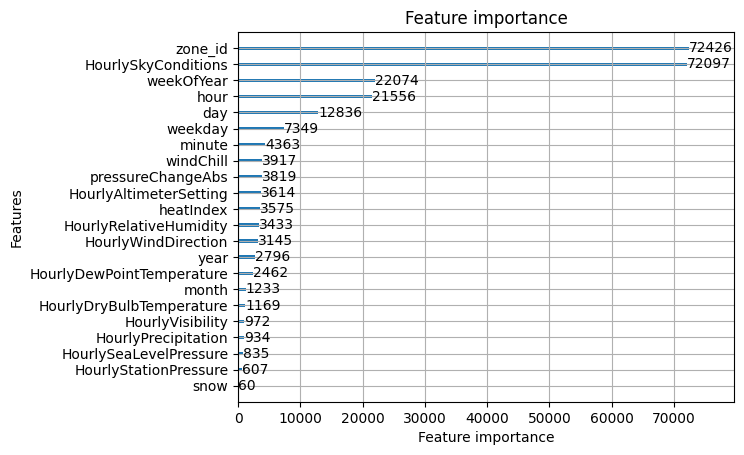

In [132]:
#アンサンブルの結果を格納（単独モデルでは使わない）
#result = meta_test_pred

#乗車予測0以下を0に
result[result < 0] = 0

#提出形式に整形
numberOfRows = len(zone_predictions)
for zone_id in range(79):
    zone_predictions[zone_id] = result[numberOfRows * zone_id : numberOfRows * (zone_id + 1)]

#提出用CSV出力
zone_predictions.to_csv('./submission_lgb.csv', index=False)

# # # 各地区ごとに予測
# # for zone_id in range(79):
# #     model = models[zone_id]
# #     zone_predictions[zone_id] = model.predict(X_test)
lgb.plot_importance(model, max_num_features=100)

In [133]:
zone_predictions.head()

,tpep_pickup_datetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
0,2019-12-01 00:00:00,32.765163,14.142161,20.627063,12.655430,9.498946,6.601356,3.959776,21.872142,11.419226,33.836810,18.074968,280.557154,54.643280,3.680498,8.220901,4.657633,186.447163,20.052244,23.414812,475.727399,37.481410,18.043617,124.796886,10.505908,106.879638,184.583264,94.499399,209.896335,8.800691,36.232977,5.585900,149.487516,75.437996,74.431891,41.655053,84.331355,140.807265,23.844829,109.887513,9.543051,7.686027,292.452150,27.231147,7.171286,122.876318,158.934908,111.046258,125.360579,181.569704,19.254509,145.169120,4.964517,13.173811,149.807128,4.745022,15.477802,69.587138,4.871598,11.776010,9.677330,84.023752,251.122978,102.609760,22.996951,43.985179,189.634008,64.971638,100.963925,58.324654,93.294764,7.767288,87.171244,269.027896,22.497112,16.969887,5.288675,24.281981,19.140905,92.080185
1,2019-12-01 00:30:00,32.765163,14.142161,20.627063,12.655430,9.498946,6.601356,3.959776,21.872142,11.419226,33.836810,18.074968,280.557154,54.643280,3.680498,8.220901,4.657633,186.447163,20.052244,23.414812,475.727399,37.481410,18.043617,124.796886,10.505908,106.879638,184.583264,94.499399,209.896335,8.800691,36.232977,5.585900,149.487516,75.437996,74.431891,41.655053,84.331355,140.807265,23.844829,109.887513,9.543051,7.686027,292.452150,27.231147,7.171286,122.876318,158.934908,111.046258,125.360579,181.569704,19.254509,145.169120,4.964517,13.173811,149.807128,4.745022,15.477802,69.587138,4.871598,11.776010,9.677330,84.023752,251.122978,102.609760,22.996951,43.985179,189.634008,64.971638,100.963925,58.324654,93.294764,7.767288,87.171244,269.027896,22.497112,16.969887,5.288675,24.281981,19.140905,92.080185
2,2019-12-01 01:00:00,35.424538,15.082501,11.247853,11.728528,9.886152,7.138476,5.295110,19.838272,12.212562,16.244826,19.170519,207.599106,48.214186,5.255828,8.816651,5.422675,185.653583,18.855924,17.882575,508.306905,28.276596,14.334992,109.366838,10.554140,72.635964,141.409465,72.659191,240.305290,9.974784,34.426823,7.395256,66.956912,71.560178,21.087160,25.964469,77.358591,75.370344,16.523250,128.130416,10.152741,8.693172,414.038805,21.911626,8.192015,166.486389,79.063700,66.520979,86.812006,150.798900,15.407547,98.780419,6.748727,12.565304,101.402995,6.377148,14.282217,62.733330,6.733483,11.054385,11.426789,78.437496,159.003744,91.419312,26.908650,34.354054,147.954968,38.536282,60.325521,35.584492,64.216977,8.800969,107.523197,280.428861,23.213114,18.061522,6.989801,16.331163,17.006492,83.143449
3,2019-12-01 01:30:00,35.424538,15.082501,11.247853,11.728528,9.886152,7.138476,5.295110,19.838272,12.212562,16.244826,19.170519,207.599106,48.214186,5.255828,8.816651,5.422675,185.653583,18.855924,17.882575,508.306905,28.276596,14.334992,109.366838,10.554140,72.635964,141.409465,72.659191,240.305290,9.974784,34.426823,7.395256,66.956912,71.560178,21.087160,25.964469,77.358591,75.370344,16.523250,128.130416,10.152741,8.693172,414.038805,21.911626,8.192015,166.486389,79.063700,66.520979,86.812006,150.798900,15.407547,98.780419,6.748727,12.565304,101.402995,6.377148,14.282217,62.733330,6.733483,11.054385,11.426789,78.437496,159.003744,91.419312,26.908650,34.354054,147.954968,38.536282,60.325521,35.584492,64.216977,8.800969,107.523197,280.428861,23.213114,18.061522,6.989801,16.331163,17.006492,83.143449
4,2019-12-01 02:00:00,25.700938,10.450161,3.419688,6.321157,4.194759,2.656299,1.251971,13.218004,6.857759,6.625797,11.016718,150.560879,36.754177,0.991065,3.770912,1.445733,159.038709,12.247811,9.648567,404.011268,12.806389,7.733129,83.582417,4.647102,45.357470,96.082740,39.801644,211.341773,5.595119,27.684589,4.207899,24.380316,48.775175,5.421647,11.087295,48.665269,25.160815,7.262135,115.320045,4.971633,4.488945,382.963394,14.408234,3.789175,148.974885,34.209507,36.140418,58.786447,11

#交差検証
from sklearn.model_selection import KFold

y_preds = []
models = []
oof_train = np.zeros((len(X_train), ))
cv = KFold(n_splits=5, shuffle=True, random_state=seed)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, : ]
    X_val = X_train.loc[valid_index, : ]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=features)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train, categorical_feature=features)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      num_boost_round=1000,
                      callbacks=[lgb.early_stopping(stopping_rounds=100,
                                verbose=True),lgb.log_evaluation(1000)]
                      )
    
    oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_preds.append(y_pred)
    models.append(model)
    